In [41]:
import nltk
import pathlib, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from tqdm.auto import tqdm

In [30]:
nltk.download('vader_lexicon')
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 110
sns.set_style('whitegrid')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/karinachadaeva/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [31]:
R_raw = pathlib.Path("republicans.txt").read_text(encoding="utf-8", errors="ignore")
D_raw = pathlib.Path("democrats.txt"  ).read_text(encoding="utf-8", errors="ignore")

In [32]:
R_docs = [d.strip() for d in R_raw.splitlines() if d.strip()]
D_docs = [d.strip() for d in D_raw.splitlines() if d.strip()]

sia = SentimentIntensityAnalyzer()

def vader(doc):
    return sia.polarity_scores(doc)['compound']

def blob(doc):
    return TextBlob(doc).sentiment.polarity

R_vader = np.array([vader(d) for d in R_docs])
D_vader = np.array([vader(d) for d in D_docs])

R_blob  = np.array([blob(d)  for d in R_docs])
D_blob  = np.array([blob(d)  for d in D_docs])

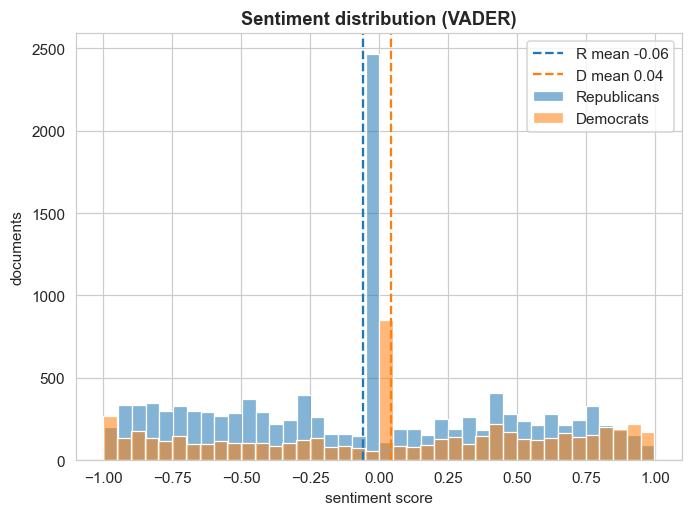

In [33]:
sns.histplot(R_vader, color='#1f77b4', label='Republicans', kde=False, stat='count', bins=40, alpha=.55)
sns.histplot(D_vader, color='#ff7f0e', label='Democrats', kde=False, stat='count', bins=40, alpha=.55)
plt.axvline(np.nanmean(R_vader), ls='--', color='#1f77b4', label=f'R mean {np.nanmean(R_vader):.2f}')
plt.axvline(np.nanmean(D_vader), ls='--', color='#ff7f0e', label=f'D mean {np.nanmean(D_vader):.2f}')
plt.title('Sentiment distribution (VADER)', weight='bold')
plt.xlabel('sentiment score')
plt.ylabel('documents')
plt.legend()
plt.tight_layout()
plt.show()

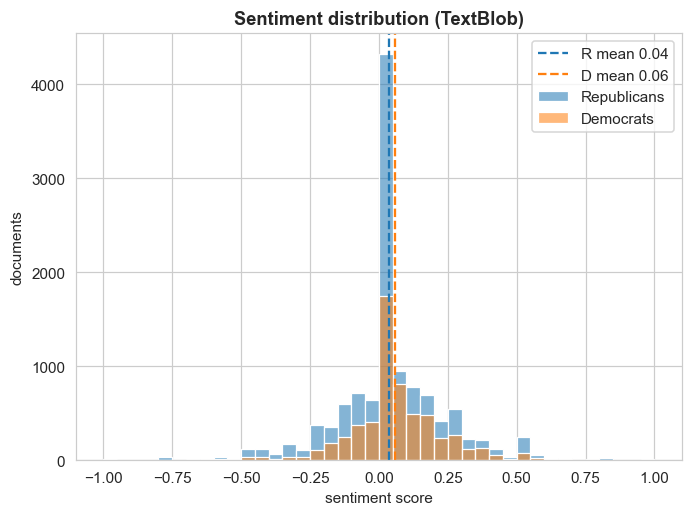

In [34]:
sns.histplot(R_blob, color='#1f77b4', label='Republicans', kde=False, stat='count', bins=40, alpha=.55)
sns.histplot(D_blob, color='#ff7f0e', label='Democrats', kde=False, stat='count', bins=40, alpha=.55)
plt.axvline(np.nanmean(R_blob), ls='--', color='#1f77b4', label=f'R mean {np.nanmean(R_blob):.2f}')
plt.axvline(np.nanmean(D_blob), ls='--', color='#ff7f0e', label=f'D mean {np.nanmean(D_blob):.2f}')
plt.title('Sentiment distribution (TextBlob)', weight='bold')
plt.xlabel('sentiment score')
plt.ylabel('documents')
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
tok = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment-latest')
bert = AutoModelForSequenceClassification.from_pretrained(
            'cardiffnlp/twitter-roberta-base-sentiment')
bert.eval()

@torch.no_grad()
def bert_score(doc):
    inputs = tok(doc, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
    logits = bert(**inputs).logits
    probs = torch.softmax(logits, dim=1).squeeze()
    # сводим к pos-neg
    return (probs[2] - probs[0]).item()

R_bert = np.array([bert_score(d) for d in R_docs])
D_bert = np.array([bert_score(d) for d in D_docs])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

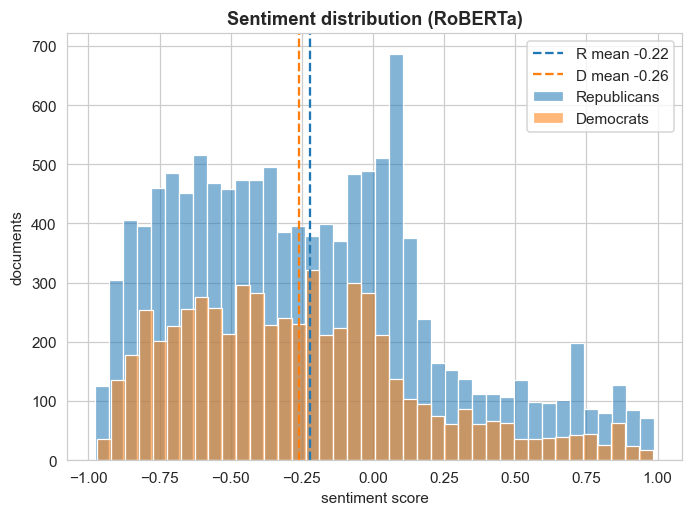

In [37]:
sns.histplot(R_bert, color='#1f77b4', label='Republicans', kde=False, stat='count', bins=40, alpha=.55)
sns.histplot(D_bert, color='#ff7f0e', label='Democrats', kde=False, stat='count', bins=40, alpha=.55)
plt.axvline(np.nanmean(R_bert), ls='--', color='#1f77b4', label=f'R mean {np.nanmean(R_bert):.2f}')
plt.axvline(np.nanmean(D_bert), ls='--', color='#ff7f0e', label=f'D mean {np.nanmean(D_bert):.2f}')
plt.title('Sentiment distribution (RoBERTa)', weight='bold')
plt.xlabel('sentiment score')
plt.ylabel('documents')
plt.legend()
plt.tight_layout()
plt.show()